In [23]:
import numpy as np
import os, sys, librosa
from scipy import signal
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import IPython.display as ipd
import pandas as pd
import math
from numba import jit
!pip install mir_eval
import mir_eval
from scipy.signal import hann
from scipy import ndimage

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Defining a Novelty Spectrum - Ref: Notebook: C6/C6S1_NoveltySpectral.ipynb

In [25]:
def compute_local_average(x, M):
    L = len(x)
    local_average = np.zeros(L)
    for m in range(L):
        a = max(m - M, 0)
        b = min(m + M + 1, L)
        local_average[m] = (1 / (2 * M + 1)) * np.sum(x[a:b])
    return local_average

In [26]:
def compute_novelty_spectrum(x, Fs=8, N=1024, H=256, gamma=100.0, M=10, norm=True):
    X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window=hann(N))
    Fs_feature = Fs / H
    Y = np.log(1 + gamma * np.abs(X))
    Y_diff = np.diff(Y)
    Y_diff[Y_diff < 0] = 0
    novelty_spectrum = np.sum(Y_diff, axis=0)
    novelty_spectrum = np.concatenate((novelty_spectrum, np.array([0.0])))
    if M > 0:
        local_average = compute_local_average(novelty_spectrum, M)
        novelty_spectrum = novelty_spectrum - local_average
        novelty_spectrum[novelty_spectrum < 0] = 0.0
    if norm:
        max_value = max(novelty_spectrum)
        if max_value > 0:
            novelty_spectrum = novelty_spectrum / max_value
    plot_novelty_spectrum(novelty_spectrum, Fs_feature)
    return novelty_spectrum, Fs_feature


In [27]:
def plot_novelty_spectrum(novelty_spectrum, Fs_feature):
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.plot(np.arange(len(novelty_spectrum)) / Fs_feature, novelty_spectrum)
    ax.set(xlabel='Time (s)', ylabel='Novelty',
           title='Novelty Spectrum')
    plt.show()

Resample Signal - for better computation and resoltuion  -  Ref - Notebook: C6/C6S1_NoveltyComparison.ipynb

In [28]:
def resample_signal(x_in, Fs_in, Fs_out=100, norm=True, time_max_sec=None, sigma=None):
    if sigma is not None:
        x_in = ndimage.gaussian_filter(x_in, sigma=sigma)
    T_coef_in = np.arange(x_in.shape[0]) / Fs_in
    time_in_max_sec = T_coef_in[-1]
    if time_max_sec is None:
        time_max_sec = time_in_max_sec
    N_out = int(np.ceil(time_max_sec*Fs_out))
    T_coef_out = np.arange(N_out) / Fs_out
    if T_coef_out[-1] > time_in_max_sec:
        x_in = np.append(x_in, [0])
        T_coef_in = np.append(T_coef_in, [T_coef_out[-1]])
    x_out = interp1d(T_coef_in, x_in, kind='linear')(T_coef_out)
    if norm:
        x_max = max(x_out)
        if x_max > 0:
            x_out = x_out / max(x_out)
    return x_out, Fs_out

Importing dataset

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
path = '/content/drive/MyDrive/BallroomData'

for folder in os.scandir(path):
  if folder.is_dir():    
    if 'ChaChaCha' in folder.name:
      bpm = 120
      ChaChaCha = np.array([folder.name, bpm], dtype=object)
    elif 'Jive' in folder.name:
      bpm = 164
      Jive = np.array([folder.name, bpm], dtype=object)
    elif 'Quickstep' in folder.name:
      bpm = 60
      Quickstep = np.array([folder.name, bpm], dtype=object)
    elif 'Rumba-American' in folder.name:
      bpm = 136
      RumbaAmerican = np.array([folder.name, bpm], dtype=object)
    elif 'Rumba-International' in folder.name:
      bpm = 108
      RumbaInternational = np.array([folder.name, bpm], dtype=object)
    elif 'Rumba-Misc' in folder.name:
      bpm = 100
      RumbaMisc = np.array([folder.name, bpm], dtype=object)
    elif 'Samba' in folder.name:
      bpm = 100
      Samba = np.array([folder.name, bpm], dtype=object)
    elif 'Tango' in folder.name:
      bpm = 126
      Tango = np.array([folder.name, bpm], dtype=object)
    elif 'VienneseWaltz' in folder.name:
      bpm = 165
      VienneseWaltz = np.array([folder.name, bpm], dtype=object)
    elif 'Waltz' in folder.name:
      bpm = 70
      Waltz = np.array([folder.name, bpm], dtype=object)


Complete_List = np.vstack([ChaChaCha, Jive, Quickstep, RumbaAmerican, RumbaInternational, RumbaMisc, Samba, Tango, VienneseWaltz, Waltz])

print(Complete_List)

[['ChaChaCha' 120]
 ['Jive' 164]
 ['Quickstep' 60]
 ['Rumba-American' 136]
 ['Rumba-International' 108]
 ['Rumba-Misc' 100]
 ['Samba' 100]
 ['Tango' 126]
 ['VienneseWaltz' 165]
 ['Waltz' 70]]


Dynamic Programming for Beat Tracking - Ref : FMP Textbook





In [31]:
def penalty_func(N, idealbeat):
    ratio = np.arange(1, N) / idealbeat
    penalty = -np.square(np.log2(ratio))
    whole_ratio = np.concatenate((np.array([0]), ratio))
    penalty = np.concatenate((np.array([0]), penalty))
    return penalty

In [32]:
def calculate_optimal_beat_sequence(novelty_function, beat_period, penalty_function=None, weight_factor=1.0, return_all_info=False):
    n = len(novelty_function)
    if penalty_function is None:
        penalty_function = penalty_func(n, beat_period)
    penalty_function = penalty_function * weight_factor
    novelty_function = np.concatenate((np.array([0]), novelty_function))
    accumulated_scores = np.zeros(n+1)
    maximization_info = np.zeros(n+1, dtype=int)
    accumulated_scores[1] = novelty_function[1]
    maximization_info[1] = 0
    # forward calculation
    for i in range(2, n+1):
        indices = np.arange(1, i)
        scores = accumulated_scores[indices] + penalty_function[i-indices]
        maximum_score = np.max(scores)
        if maximum_score <= 0:
            accumulated_scores[i] = novelty_function[i]
            maximization_info[i] = 0
        else:
            accumulated_scores[i] = novelty_function[i] + maximum_score
            maximization_info[i] = np.argmax(scores) + 1
    # backtracking
    optimal_beat_sequence = np.zeros(n, dtype=int)
    k = 0
    optimal_beat_sequence[k] = np.argmax(accumulated_scores)
    while maximization_info[optimal_beat_sequence[k]] != 0:
        k += 1
        optimal_beat_sequence[k] = maximization_info[optimal_beat_sequence[k-1]]
    optimal_beat_sequence = optimal_beat_sequence[0:k+1]
    optimal_beat_sequence = optimal_beat_sequence[::-1]
    optimal_beat_sequence = optimal_beat_sequence - 1
    if return_all_info:
        return optimal_beat_sequence, accumulated_scores, maximization_info
    else:
        return optimal_beat_sequence

In [33]:
def Tracker(inputFile, nov, Fs_nov, dataArray):

  beat_ref = int(dataArray[1])
  beats = calculate_optimal_beat_sequence(nov, beat_period=beat_ref)
  beats_new = np.zeros(len(nov))
  beats_new[np.array(beats, dtype=np.int32)] = 1
  T_coef_beats = np.arange(nov.shape[0]) / Fs_nov
  beats_sec = T_coef_beats[beats]
  return beats_sec

In [34]:
def beatTracker(inputFile):

  Fs = 22050
  for folder in os.scandir(path):
    if folder.is_dir():
      for file in os.scandir(folder):
        if inputFile in file.name:
            i = np.where(Complete_List == folder.name)[0]
            dataArray = Complete_List[i,:][0] 
            print(dataArray)          
            
            x, Fs = librosa.load(file.path, Fs)             
            nov, Fs_nov = compute_novelty_spectrum(x, Fs=Fs, N=2048, H=512, gamma=100, M=10, norm=True)
            nov, Fs_nov = resample_signal(nov, Fs_in=Fs_nov, Fs_out=100)
            beats_sec = Tracker(inputFile, nov, Fs_nov, dataArray)
            print(inputFile)
            print("Beat times:", beats_sec)
  return beats_sec


['Waltz' 70]


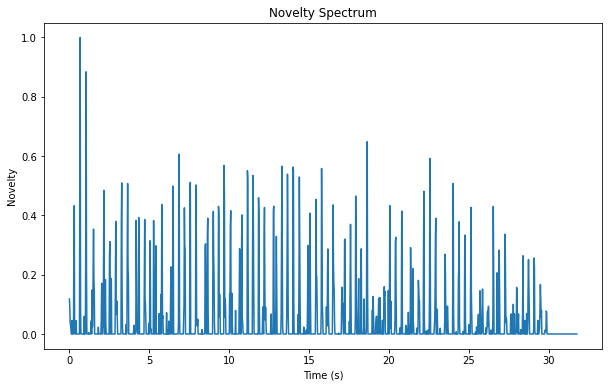

Media-103301.wav
Beat times: [ 0.    0.67  1.51  2.16  2.9   3.64  4.35  5.04  5.79  6.48  7.2   7.92
  8.66  9.34 10.1  10.8  11.49 12.21 12.96 13.65 14.4  15.07 15.79 16.51
 17.23 17.93 18.64 19.36 20.06 20.82 21.5  22.2  22.94 23.53 24.4  25.15
 25.87 26.54 27.29 28.01 28.75 29.49]


In [40]:
k =beatTracker('Media-103301.wav')

file_name = 'Media-103301.wav'

Evaluation


In [41]:
annot_path = "/content/drive/MyDrive/BallroomAnnotations-master"
full_path = os.path.join(annot_path, file_name)
base_name, ext = os.path.splitext(full_path)
new_ext = ".beats"
new_full_path = base_name + new_ext

# Read the ground truth beat times from the annotation file
with open(new_full_path, 'r', encoding='utf-8') as f:
    lines = f.readlines()

gt_beats = []   # list to store ground truth beat times
for line in lines:
    segment = line.split(' ')
    time = float(segment[0])
    gt_beats.append(time)
gt = np.array(gt_beats)

In [42]:
mir_eval.beat.evaluate(gt, k)

OrderedDict([('F-measure', 0.7142857142857143),
             ('Cemgil', 0.4944074505401655),
             ('Cemgil Best Metric Level', 0.4944074505401655),
             ('Goto', 0.0),
             ('P-score', 0.9714285714285714),
             ('Correct Metric Level Continuous', 0.7428571428571429),
             ('Correct Metric Level Total', 0.9428571428571428),
             ('Any Metric Level Continuous', 0.7428571428571429),
             ('Any Metric Level Total', 0.9428571428571428),
             ('Information gain', 0.5371553559251475)])

In [43]:
x, sr = librosa.load('/content/drive/MyDrive/BallroomData/Waltz/Media-103301.wav') 
ipd.Audio(x, rate=sr)

In [44]:
clicks = librosa.clicks(k, sr=sr, length=len(x))
ipd.Audio(x + clicks, rate=sr)